### Uncomment code to train from scratch, dont uncomment if just for reproducibility

In [2]:
import os
import pandas as pd

# Resolve repo root
SCRIPT_DIR = os.getcwd()
REPO_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, "..", ".."))

# Define data paths
resistant_path = os.path.join(REPO_ROOT, "data", "res_mdr_xdr", "resistant_df_no_duplicates.csv")
mdr_path = os.path.join(REPO_ROOT, "data", "res_mdr_xdr", "mdr_no_duplicates.csv")
h37rv_path = os.path.join(REPO_ROOT, "data", "cv", "h37rv_filtered_data_no_duplicates.csv")

# Load datasets
resistant_df = pd.read_csv(resistant_path)
mdr_df = pd.read_csv(mdr_path)
h37rv_df = pd.read_csv(h37rv_path)

/tmp/ipykernel_1809776/4036890467.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


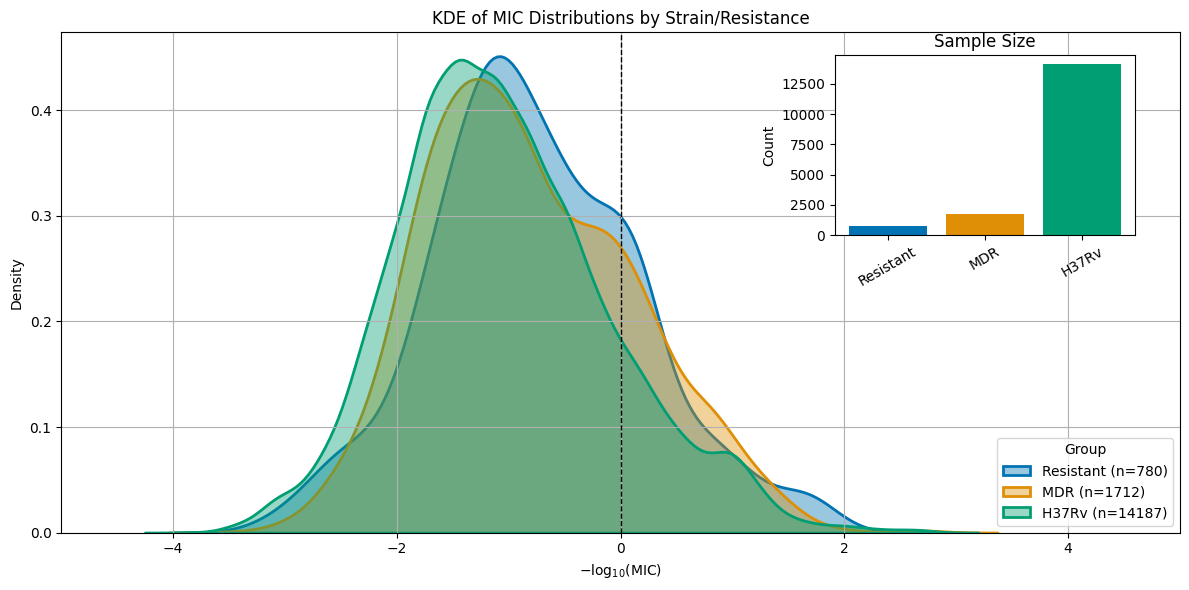

In [3]:
#plot the distribution of the three in the same plot (mic_log column)
resistant_df['mic_log'] = resistant_df['mic_log'].astype(float)
mdr_df['mic_log'] = mdr_df['mic_log'].astype(float)
h37rv_df['mic_log'] = h37rv_df['mic_log'].astype(float)


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

counts = {
    'Resistant': len(resistant_df),
    'MDR': len(mdr_df),
    'H37Rv': len(h37rv_df)
}

sns.set_palette("colorblind")
colors = sns.color_palette("colorblind", len(counts))
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(resistant_df['mic_log'], label=f'Resistant (n={len(resistant_df)})',
            fill=True, alpha=0.4, linewidth=2)
sns.kdeplot(mdr_df['mic_log'], label=f'MDR (n={len(mdr_df)})',
            fill=True, alpha=0.4, linewidth=2)
sns.kdeplot(h37rv_df['mic_log'], label=f'H37Rv (n={len(h37rv_df)})',
            fill=True, alpha=0.4, linewidth=2)

ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_title('KDE of MIC Distributions by Strain/Resistance')
ax.set_xlabel(r'$\mathrm{-log_{10}(MIC)}$')
ax.set_ylabel('Density')
ax.set_xlim(-5, 5)
ax.grid()
ax.legend(title='Group', loc='lower right')

# Inset bar plot
inset_ax = fig.add_axes([0.7, 0.6, 0.25, 0.3])  # [left, bottom, width, height]
inset_ax.bar(counts.keys(), counts.values(), color=colors)
inset_ax.set_title('Sample Size')
inset_ax.set_ylabel('Count')
inset_ax.tick_params(axis='x', labelrotation=30)

plt.tight_layout()
plt.show()

In [4]:
#check class balance for each dataset using different thresholds
def add_binary_label(df, threshold):
    threshold_log = -np.log10(threshold)
    df['label'] = np.where(df['mic_log'] > threshold_log, 1, 0)
    class_counts = df['label'].value_counts()
    return df, class_counts

threshold = 10


print(f"Threshold: {threshold}")

resistant_df, resistant_counts = add_binary_label(resistant_df, threshold)
mdr_df, mdr_counts = add_binary_label(mdr_df, threshold)
h37rv_df, h37rv_counts = add_binary_label(h37rv_df, threshold)

print(f"Resistant counts:\n{resistant_counts}\n")
print(f"MDR counts:\n{mdr_counts}\n")
print(f"H37Rv counts:\n{h37rv_counts}\n")

Threshold: 10
Resistant counts:
label
1    433
0    347
Name: count, dtype: int64

MDR counts:
label
1    906
0    806
Name: count, dtype: int64

H37Rv counts:
label
0    7954
1    6233
Name: count, dtype: int64



In [5]:
#check number of smiles shared between datasets
def check_smiles_overlap(df1, df2):
    overlap = len(set(df1['canonical_smiles']).intersection(set(df2['canonical_smiles'])))
    return overlap

resistant_mdr_overlap = check_smiles_overlap(resistant_df, mdr_df)
resistant_h37rv_overlap = check_smiles_overlap(resistant_df, h37rv_df)
mdr_h37rv_overlap = check_smiles_overlap(mdr_df, h37rv_df)
print(f"Resistant and MDR overlap: {resistant_mdr_overlap}")
print(f"Resistant and H37Rv overlap: {resistant_h37rv_overlap}")
print(f"MDR and H37Rv overlap: {mdr_h37rv_overlap}")


#check number of smiles shared between 3 datasets
def check_smiles_overlap_all(df1, df2, df3):
    overlap = len(set(df1['canonical_smiles']).intersection(set(df2['canonical_smiles'])).intersection(set(df3['canonical_smiles'])))
    return overlap

resistant_mdr_h37rv_overlap = check_smiles_overlap_all(resistant_df, mdr_df, h37rv_df)
print(f"Resistant, MDR and H37Rv overlap: {resistant_mdr_h37rv_overlap}")

Resistant and MDR overlap: 192
Resistant and H37Rv overlap: 644
MDR and H37Rv overlap: 1167
Resistant, MDR and H37Rv overlap: 146


In [6]:
# Get the actual overlapping SMILES (not just the count)
def get_smiles_overlap_all(df1, df2, df3):
    return set(df1['canonical_smiles']) & set(df2['canonical_smiles']) & set(df3['canonical_smiles'])

# Get overlapping SMILES
overlap_smiles = get_smiles_overlap_all(resistant_df, mdr_df, h37rv_df)

# Filter each df to just those 146 SMILES
resistant_overlap_df = resistant_df[resistant_df['canonical_smiles'].isin(overlap_smiles)]
mdr_overlap_df = mdr_df[mdr_df['canonical_smiles'].isin(overlap_smiles)]
h37rv_overlap_df = h37rv_df[h37rv_df['canonical_smiles'].isin(overlap_smiles)]

# Print class balance per task
print("Class balance among the 146 overlapping compounds:\n")
print("🧪 Resistant:")
print(resistant_overlap_df['label'].value_counts(), '\n')

print("🧪 MDR:")
print(mdr_overlap_df['label'].value_counts(), '\n')

print("🧪 H37Rv:")
print(h37rv_overlap_df['label'].value_counts(), '\n')

Class balance among the 146 overlapping compounds:

🧪 Resistant:
label
1    105
0     41
Name: count, dtype: int64 

🧪 MDR:
label
1    93
0    53
Name: count, dtype: int64 

🧪 H37Rv:
label
1    124
0     22
Name: count, dtype: int64 



In [7]:
known_antibiotics = {
    'Isoniazid': 'NNC(=O)c1ccncc1',
    'Rifampicin': 'CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CCN(C)CC5)c(O)c4c3C2=O)NC(=O)/C(C)=C\C=C\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C',
    'Ethambutol': 'CC[C@@H](CO)NCCN[C@@H](CC)CO',
    'Streptomycin': 'CN[C@@H]1[C@H](O[C@H]2[C@H](O[C@H]3[C@H](O)[C@@H](O)[C@H](N=C(N)N)[C@@H](O)[C@@H]3N=C(N)N)O[C@@H](C)[C@]2(O)C=O)O[C@@H](CO)[C@H](O)[C@H]1O',
    'Pyrazinamide': 'NC(=O)c1cnccn1',
    'Ethionamide': 'CCc1cc(C(N)=S)ccn1',
    'Kanamycin': 'NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[C@H](CO)[C@@H](O)[C@H](N)[C@H]3O)[C@H](N)C[C@@H]2N)[C@H](O)[C@@H](O)[C@@H]1O',
    'Ciprofloxacin': 'O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O',
    'Ofloxacin': 'CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23',
    'Amikacin': 'NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]2O[C@H](CN)[C@@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@H]1O[C@H]1O[C@H](CO)[C@@H](O)[C@H](N)[C@H]1O',
    'Cycloserine': 'N[C@@H]1CONC1=O',
    'Capreomycin': 'C[C@@H]1NC(=O)[C@@H](N)CNC(=O)[C@H](C2CCNC(=N)N2)NC(=O)/C(=C/NC(N)=O)NC(=O)[C@H](CNC(=O)CC(N)CCCN)NC1=O.N=C1NCCC([C@@H]2NC(=O)/C(=C/NC(N)=O)NC(=O)[C@H](CNC(=O)CC(N)CCCN)NC(=O)[C@H](CO)NC(=O)[C@@H](N)CNC2=O)N1'
}


In [8]:
overlap_df = pd.merge(resistant_overlap_df[['canonical_smiles', 'label']], 
                      mdr_overlap_df[['canonical_smiles', 'label']], 
                      on='canonical_smiles', suffixes=('_resistant', '_mdr'))

overlap_df = pd.merge(overlap_df, 
                      h37rv_overlap_df[['canonical_smiles', 'label']].rename(columns={'label': 'label_h37rv'}),
                      on='canonical_smiles')

overlap_df.to_csv("multitask_test_set.csv", index=False)

In [9]:
# Get the set of overlap SMILES (already computed earlier)
overlap_smiles = set(overlap_df['canonical_smiles'])

# Filter out overlap compounds from each dataset
resistant_df_clean = resistant_df[~resistant_df['canonical_smiles'].isin(overlap_smiles)].copy()
mdr_df_clean = mdr_df[~mdr_df['canonical_smiles'].isin(overlap_smiles)].copy()
h37rv_df_clean = h37rv_df[~h37rv_df['canonical_smiles'].isin(overlap_smiles)].copy()

h37rv_df.shape[0]-h37rv_df_clean.shape[0], mdr_df.shape[0]-mdr_df_clean.shape[0], resistant_df.shape[0]-resistant_df_clean.shape[0]


(146, 146, 146)

In [10]:
overlap_df

,canonical_smiles,label_resistant,label_mdr,label_h37rv
0,NC(=O)c1cnccn1,0,0,0
1,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C...,1,0,1
2,CC[C@@H](CO)NCCN[C@@H](CC)CO,1,0,1
3,NNC(=O)c1ccncc1,1,0,1
4,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,0,0,1
...,...,...,...,...
141,C[C@]1(Cn2cc(COc3ccccn3)nn2)Cn2cc([N+](=O)[O-]...,1,1,1
142,Cc1ccc(SCc2cn(C[C@@]3(C)Cn4cc([N+](=O)[O-])nc4...,1,1,1
143,Cc1ccc(OCCc2cn(C[C@@]3(C)Cn4cc([N+](=O)[O-])nc...,1,1,1
144,C[C@]1(Cn2cc(CN3CCOCC3)nn2)Cn2cc([N+](=O)[O-])...,1,1,1


In [11]:
# Step 2: Convert the overlap set to a set of SMILES for quick lookup
overlap_smiles_set = set(overlap_df['canonical_smiles'])

print("🔍 Antibiotics in the 146-compound overlap set:\n")
for name, canon_smiles in known_antibiotics.items():
    if canon_smiles in overlap_smiles_set:
        print(f"\n✅ {name} FOUND")
        labels = overlap_df[overlap_df['canonical_smiles'] == canon_smiles]
        print("Labels:")
        print(f"  H37Rv     : {labels['label_h37rv'].values[0]}")
        print(f"  Resistant : {labels['label_resistant'].values[0]}")
        print(f"  MDR       : {labels['label_mdr'].values[0]}")
    else:
        print(f"\n❌ {name} not found")

🔍 Antibiotics in the 146-compound overlap set:


✅ Isoniazid FOUND
Labels:
  H37Rv     : 1
  Resistant : 1
  MDR       : 0

✅ Rifampicin FOUND
Labels:
  H37Rv     : 1
  Resistant : 1
  MDR       : 0

✅ Ethambutol FOUND
Labels:
  H37Rv     : 1
  Resistant : 1
  MDR       : 0

✅ Streptomycin FOUND
Labels:
  H37Rv     : 1
  Resistant : 1
  MDR       : 0

✅ Pyrazinamide FOUND
Labels:
  H37Rv     : 0
  Resistant : 0
  MDR       : 0

❌ Ethionamide not found

✅ Kanamycin FOUND
Labels:
  H37Rv     : 1
  Resistant : 0
  MDR       : 0

✅ Ciprofloxacin FOUND
Labels:
  H37Rv     : 1
  Resistant : 1
  MDR       : 1

✅ Ofloxacin FOUND
Labels:
  H37Rv     : 1
  Resistant : 0
  MDR       : 0

✅ Amikacin FOUND
Labels:
  H37Rv     : 1
  Resistant : 1
  MDR       : 1

✅ Cycloserine FOUND
Labels:
  H37Rv     : 0
  Resistant : 0
  MDR       : 0

❌ Capreomycin not found


In [12]:
h37rv_df_clean.label.value_counts(),  resistant_df_clean.label.value_counts(), mdr_df_clean.label.value_counts()

(label
 0    7932
 1    6109
 Name: count, dtype: int64,
 label
 1    328
 0    306
 Name: count, dtype: int64,
 label
 1    813
 0    753
 Name: count, dtype: int64)

In [13]:
resistant_mdr_overlap = check_smiles_overlap(resistant_df_clean, mdr_df_clean)
resistant_h37rv_overlap = check_smiles_overlap(resistant_df_clean, h37rv_df_clean)
mdr_h37rv_overlap = check_smiles_overlap(mdr_df_clean, h37rv_df_clean)
print(f"Resistant and MDR overlap: {resistant_mdr_overlap}")
print(f"Resistant and H37Rv overlap: {resistant_h37rv_overlap}")
print(f"MDR and H37Rv overlap: {mdr_h37rv_overlap}")

resistant_mdr_h37rv_overlap = check_smiles_overlap_all(resistant_df_clean, mdr_df_clean, h37rv_df_clean)
print(f"Resistant, MDR and H37Rv overlap: {resistant_mdr_h37rv_overlap}")

Resistant and MDR overlap: 46
Resistant and H37Rv overlap: 498
MDR and H37Rv overlap: 1021
Resistant, MDR and H37Rv overlap: 0


In [14]:
all_smiles = set(resistant_df_clean['canonical_smiles']) | \
             set(mdr_df_clean['canonical_smiles']) | \
             set(h37rv_df_clean['canonical_smiles'])

all_smiles = sorted(list(all_smiles))

In [15]:
import os
import sys
import pickle

# Set repo root and append to sys.path
SCRIPT_DIR = os.getcwd()
REPO_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, "..", ".."))
sys.path.append(REPO_ROOT)

from utils import smiles_to_embeddings

# Prepare save directory
save_dir = os.path.join(REPO_ROOT, "data", "res_mdr_xdr")
os.makedirs(save_dir, exist_ok=True)
embedding_path = os.path.join(save_dir, "kpgt_embeddings.pkl")



# Define KPGT paths based on your known structure
KPGT_ROOT = os.path.expanduser("~/predator/KPGT")
ENV_PYTHON = os.path.expanduser("~/miniconda3/envs/KPGT/bin/python")
MODEL_PATH = os.path.join(KPGT_ROOT, "models", "pretrained", "base", "base.pth")



# # Generate embeddings
# fps_array = smiles_to_embeddings(
#     smiles=all_smiles,
#     gpu=0,
#     kpgt_root=KPGT_ROOT,
#     env_python=ENV_PYTHON,
#     model_path=MODEL_PATH
# )

# # Map SMILES to embeddings
# smiles_to_fp = {smi: fps_array[i] for i, smi in enumerate(all_smiles)}


# # Save
# with open(embedding_path, "wb") as f:
#     pickle.dump(smiles_to_fp, f)

# Load (for later reuse)
with open(embedding_path, "rb") as f:
    smiles_to_fp = pickle.load(f)


In [16]:
def add_embeddings(df, smiles_to_fp):
    df['embedding'] = df['canonical_smiles'].map(smiles_to_fp)
    return df

resistant_df_clean = add_embeddings(resistant_df_clean, smiles_to_fp)
mdr_df_clean = add_embeddings(mdr_df_clean, smiles_to_fp)
h37rv_df_clean = add_embeddings(h37rv_df_clean, smiles_to_fp)

In [17]:
h37rv_df_clean = h37rv_df_clean.rename(columns={'label': 'label_h37rv'})
resistant_df_clean = resistant_df_clean.rename(columns={'label': 'label_resistant'})
mdr_df_clean = mdr_df_clean.rename(columns={'label': 'label_mdr'})


In [18]:
# Start with H37Rv
merged_df = h37rv_df_clean[['canonical_smiles', 'embedding', 'label_h37rv']].copy()

# Merge resistant
merged_df = merged_df.merge(
    resistant_df_clean[['canonical_smiles', 'label_resistant']],
    on='canonical_smiles', how='outer'
)

# Merge MDR
merged_df = merged_df.merge(
    mdr_df_clean[['canonical_smiles', 'label_mdr']],
    on='canonical_smiles', how='outer'
)

# Fill embedding if missing (from any source)
embedding_dict = {
    row['canonical_smiles']: row['embedding']
    for df in [h37rv_df_clean, resistant_df_clean, mdr_df_clean]
    for _, row in df.iterrows()
}

merged_df['embedding'] = merged_df['canonical_smiles'].map(embedding_dict)

# Drop any rows where embeddings are still missing (shouldn't happen)
merged_df.dropna(subset=['embedding'], inplace=True)

print("✅ Merged dataset shape:", merged_df.shape)


✅ Merged dataset shape: (14676, 5)


In [19]:
# multitask_path = os.path.join(save_dir, "multitask_dataset.pkl")
# merged_df.to_pickle(multitask_path)

In [20]:
import torch
from torch.utils.data import Dataset

class MultitaskDataset(Dataset):
    def __init__(self, df, task_names, embedding_col='embedding'):
        self.df = df.reset_index(drop=True)
        self.task_names = task_names
        self.embedding_col = embedding_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        x = torch.tensor(row[self.embedding_col], dtype=torch.float32)
        
        labels = {
            task: torch.tensor(row[task], dtype=torch.float32)
            if not pd.isna(row[task]) else torch.tensor(float('nan'))
            for task in self.task_names
        }

        return {'x': x, 'labels': labels}


In [21]:
def multitask_collate_fn(batch):
    x_batch = torch.stack([item['x'] for item in batch])
    labels_batch = {
        task: torch.stack([item['labels'][task] for item in batch])
        for task in batch[0]['labels']
    }
    return x_batch, labels_batch


In [22]:
task_names = ['label_h37rv', 'label_resistant', 'label_mdr']

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    merged_df,
    test_size=0.1,
    random_state=42,
    stratify=merged_df['label_h37rv'].fillna(-1)  # or any available task
)

train_dataset = MultitaskDataset(train_df, task_names)
val_dataset = MultitaskDataset(val_df, task_names)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=multitask_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=multitask_collate_fn)

In [23]:
label_availability = {task: (~merged_df[task].isna()).sum() for task in task_names}
print("✅ Label counts:", label_availability)

✅ Label counts: {'label_h37rv': np.int64(14041), 'label_resistant': np.int64(634), 'label_mdr': np.int64(1566)}


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC

class MultitaskLitModule(pl.LightningModule):
    def __init__(self, task_names, input_dim, hidden_dim=256, task_weights=None, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.task_names = task_names
        self.lr = lr

        # Shared encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Task-specific heads
        self.heads = nn.ModuleDict({
            task: nn.Linear(hidden_dim, 1) for task in task_names
        })

        # Loss weights
        self.task_weights = task_weights or {task: 1.0 for task in task_names}

        # Metrics
        self.metrics = nn.ModuleDict({
            task: nn.ModuleDict({
                'acc': BinaryAccuracy(),
                'auroc': BinaryAUROC()
            }) for task in task_names
        })

    def forward(self, x):
        shared = self.encoder(x)
        return {task: self.heads[task](shared).squeeze(-1) for task in self.task_names}

    def compute_loss(self, preds, labels):
        loss = 0
        for task in self.task_names:
            y = labels[task]
            mask = ~torch.isnan(y)
            if mask.sum() > 0:
                task_loss = F.binary_cross_entropy_with_logits(preds[task][mask], y[mask])
                loss += self.task_weights[task] * task_loss
        return loss

    def training_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.compute_loss(preds, labels)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        preds = self(x)
        loss = self.compute_loss(preds, labels)
        self.log("val_loss", loss)

        for task in self.task_names:
            y = labels[task]
            mask = ~torch.isnan(y)
            if mask.sum() > 0:
                logits = preds[task][mask]
                probs = torch.sigmoid(logits)
                self.metrics[task]['acc'](probs, y[mask].int())
                self.metrics[task]['auroc'](probs, y[mask].int())

        return loss

    def on_validation_epoch_end(self):
        for task in self.task_names:
            self.log(f"{task}/acc", self.metrics[task]['acc'].compute(), prog_bar=True)
            self.log(f"{task}/auroc", self.metrics[task]['auroc'].compute(), prog_bar=True)
            self.metrics[task]['acc'].reset()
            self.metrics[task]['auroc'].reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [25]:
task_counts = {'label_h37rv': 14041, 'label_resistant': 634, 'label_mdr': 1566}
inv_freq = {k: 1/v for k, v in task_counts.items()}
total = sum(inv_freq.values())
task_weights = {k: v/total for k, v in inv_freq.items()}

In [20]:
# from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks import ModelCheckpoint

# model = MultitaskLitModule(
#     task_names=task_names,
#     input_dim=2304,  # KPGT embedding size
#     task_weights=task_weights
# )

# from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# callbacks = [
#     EarlyStopping(monitor="val_loss", mode="min", patience=5),
#     ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)
# ]

# trainer = Trainer(
#     max_epochs=100,
#     accelerator="gpu", devices=1,
#     callbacks=callbacks
# )

# trainer.fit(model, train_loader, val_loader)

In [ ]:
# Create list of SMILES
test_smiles = overlap_df['canonical_smiles'].tolist()

# Generate embeddings (must pass the correct extra arguments)
test_embeddings = smiles_to_embeddings(
    smiles=test_smiles,
    gpu=0,
    kpgt_root=KPGT_ROOT,
    env_python=ENV_PYTHON,
    model_path=MODEL_PATH
)

# Build SMILES → embedding mapping
smiles_to_fp_test = {smi: emb for smi, emb in zip(test_smiles, test_embeddings)}

# Map embeddings back into the dataframe
overlap_df['embedding'] = overlap_df['canonical_smiles'].map(smiles_to_fp_test)

Using backend: pytorch
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.


constructing graphs


Using backend: pytorch
Using backend: pytorchUsing backend: pytorch

Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
Using backend: pytorch
[Parallel(n_jobs=32)]: Done 146 out of 146 | elapsed:    2.9s finished


saving graphs
extracting fingerprints
saving fingerprints
extracting molecular descriptors
🧠 Extracting features...46


Using backend: pytorch


The extracted features were saved at /home/malves/predator/KPGT/datasets//23-04-2025_22-49-07/kpgt_base.npz


In [28]:
#confirms none of the test set smiles are in the train set and validation set
overlap_df['canonical_smiles'].isin(train_df['canonical_smiles']).sum() == 0, overlap_df['canonical_smiles'].isin(val_df['canonical_smiles']).sum() == 0

(np.True_, np.True_)

In [29]:
# Reuse the same task names
test_dataset = MultitaskDataset(overlap_df, task_names)

from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=multitask_collate_fn)


In [43]:
model = MultitaskLitModule.load_from_checkpoint(
    "lightning_logs/version_2/checkpoints/epoch=6-step=1449.ckpt",
    task_names=task_names,
    input_dim=2304,
    task_weights=task_weights
)
model.eval()

MultitaskLitModule(
  (encoder): Sequential(
    (0): Linear(in_features=2304, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (heads): ModuleDict(
    (label_h37rv): Linear(in_features=256, out_features=1, bias=True)
    (label_resistant): Linear(in_features=256, out_features=1, bias=True)
    (label_mdr): Linear(in_features=256, out_features=1, bias=True)
  )
  (metrics): ModuleDict(
    (label_h37rv): ModuleDict(
      (acc): BinaryAccuracy()
      (auroc): BinaryAUROC()
    )
    (label_resistant): ModuleDict(
      (acc): BinaryAccuracy()
      (auroc): BinaryAUROC()
    )
    (label_mdr): ModuleDict(
      (acc): BinaryAccuracy()
      (auroc): BinaryAUROC()
    )
  )
)

In [ ]:
all_preds = {task: [] for task in task_names}
all_labels = {task: [] for task in task_names}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)  # ⬅️ Move input to GPU

        preds = model(x)
        for task in task_names:
            y_true = labels[task]
            mask = ~torch.isnan(y_true)
            if mask.sum() > 0:
                y_pred = torch.sigmoid(preds[task][mask].detach().cpu()).numpy()
                y_true = y_true[mask].cpu().numpy()

                all_preds[task].extend(y_pred)
                all_labels[task].extend(y_true)

In [45]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, matthews_corrcoef,
    precision_score, recall_score, average_precision_score
)

print("📊 Test set metrics (146 overlapping compounds):\n")

for task in task_names:
    y_true = all_labels[task]
    y_pred = all_preds[task]

    # Binary predictions
    y_pred_binary = [p >= 0.5 for p in y_pred]

    # Metrics
    auc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    prec = precision_score(y_true, y_pred_binary)
    rec = recall_score(y_true, y_pred_binary)

    print(f"🔹 {task}")
    print(f"   AUROC     : {auc:.3f}")
    print(f"   PR AUC    : {pr_auc:.3f}")
    print(f"   Accuracy  : {acc:.3f}")
    print(f"   MCC       : {mcc:.3f}")
    print(f"   F1 Score  : {f1:.3f}")
    print(f"   Precision : {prec:.3f}")
    print(f"   Recall    : {rec:.3f}\n")

📊 Test set metrics (146 overlapping compounds):

🔹 label_h37rv
   AUROC     : 0.845
   PR AUC    : 0.971
   Accuracy  : 0.760
   MCC       : 0.406
   F1 Score  : 0.843
   Precision : 0.949
   Recall    : 0.758

🔹 label_resistant
   AUROC     : 0.778
   PR AUC    : 0.907
   Accuracy  : 0.726
   MCC       : 0.332
   F1 Score  : 0.808
   Precision : 0.816
   Recall    : 0.800

🔹 label_mdr
   AUROC     : 0.628
   PR AUC    : 0.705
   Accuracy  : 0.610
   MCC       : 0.194
   F1 Score  : 0.674
   Precision : 0.720
   Recall    : 0.634



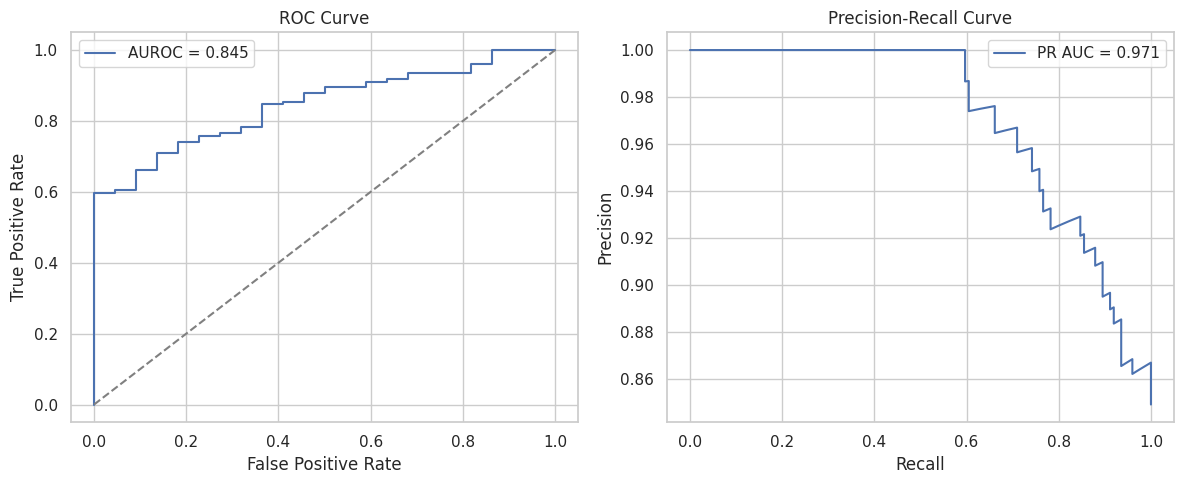

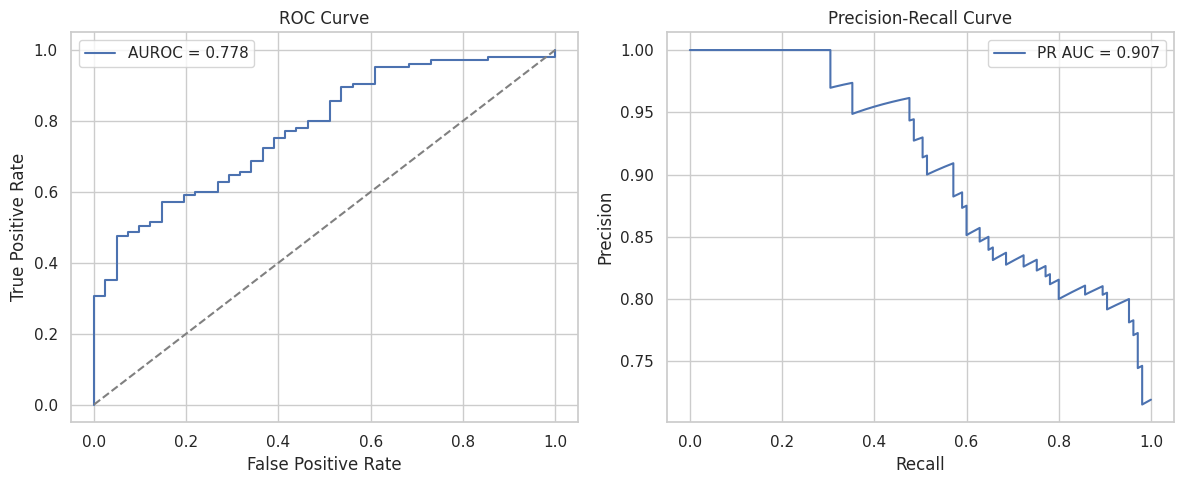

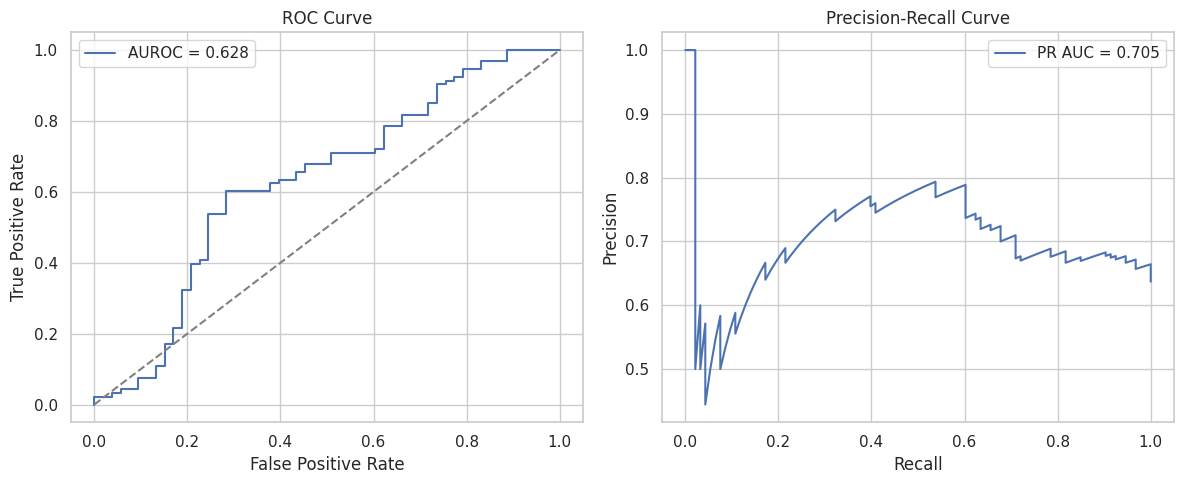

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)



for task in task_names:
    y_true = all_labels[task]
    y_pred = all_preds[task]

    auroc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    # PR curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    # Plotting
    plt.figure(figsize=(12, 5))

    # --- ROC curve ---
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUROC = {auroc:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # --- PR curve ---
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [47]:
#print label balance of test set
overlap_df['label_h37rv'].value_counts(), overlap_df['label_resistant'].value_counts(), overlap_df['label_mdr'].value_counts()

(label_h37rv
 1    124
 0     22
 Name: count, dtype: int64,
 label_resistant
 1    105
 0     41
 Name: count, dtype: int64,
 label_mdr
 1    93
 0    53
 Name: count, dtype: int64)

In [48]:
import pandas as pd

rows = []

for task in task_names:
    y_true = all_labels[task]
    y_pred = all_preds[task]

    for i, (true, prob) in enumerate(zip(y_true, y_pred)):
        pred = int(prob >= 0.5)
        error_type = (
            "TP" if pred == 1 and true == 1 else
            "TN" if pred == 0 and true == 0 else
            "FP" if pred == 1 and true == 0 else
            "FN"
        )

        rows.append({
            "index": i,
            "task": task,
            "true_label": int(true),
            "pred_label": pred,
            "probability": prob,
            "error_type": error_type
        })

df_errors = pd.DataFrame(rows)


In [49]:
overlap_df = overlap_df.reset_index(drop=True)
df_errors["smiles"] = df_errors["index"].map(overlap_df["canonical_smiles"])
df_errors["embedding"] = df_errors["index"].map(overlap_df["embedding"])


In [50]:
# Example: create a UMAP 2D projection of embeddings
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

# Use the same embeddings from overlap_df
X = np.stack(overlap_df['embedding'].values)

# UMAP
umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

# Attach to df_errors
overlap_df["umap_x"] = X_umap[:, 0]
overlap_df["umap_y"] = X_umap[:, 1]


/home/malves/miniconda3/envs/predinhib/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/malves/miniconda3/envs/predinhib/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


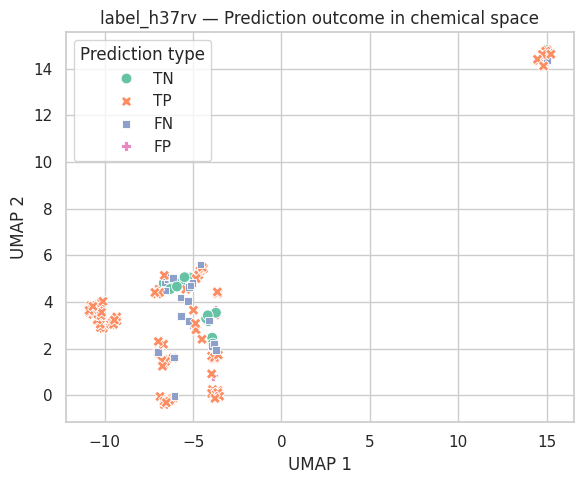

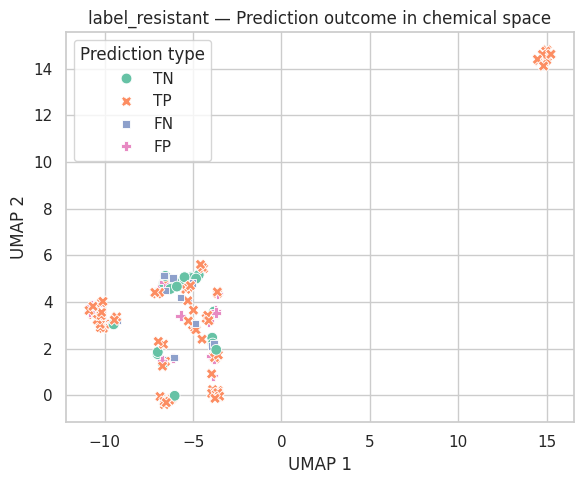

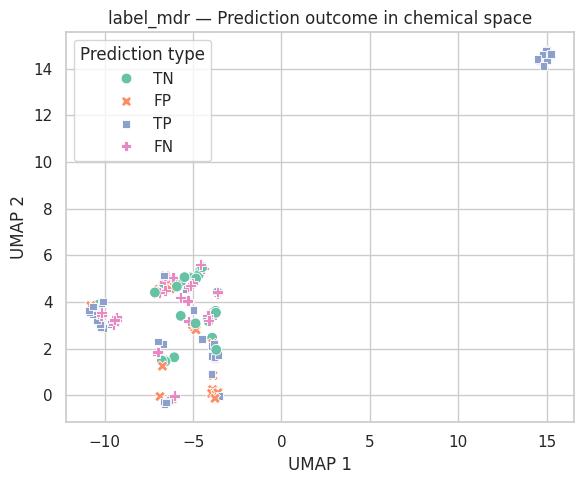

In [51]:
df_errors = df_errors.merge(
    overlap_df[['canonical_smiles', 'umap_x', 'umap_y']],
    left_on='smiles', right_on='canonical_smiles', how='left'
)


import matplotlib.pyplot as plt
import seaborn as sns

for task in task_names:
    subset = df_errors[df_errors["task"] == task]

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=subset,
        x="umap_x", y="umap_y",
        hue="error_type", style="error_type", s=60,
        palette="Set2"
    )
    plt.title(f"{task} — Prediction outcome in chemical space")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Prediction type")
    plt.tight_layout()
    plt.show()

In [52]:
known_antibiotics

{'Isoniazid': 'NNC(=O)c1ccncc1',
 'Rifampicin': 'CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(/C=N/N5CCN(C)CC5)c(O)c4c3C2=O)NC(=O)/C(C)=C\\C=C\\[C@H](C)[C@H](O)[C@@H](C)[C@@H](O)[C@@H](C)[C@H](OC(C)=O)[C@@H]1C',
 'Ethambutol': 'CC[C@@H](CO)NCCN[C@@H](CC)CO',
 'Streptomycin': 'CN[C@@H]1[C@H](O[C@H]2[C@H](O[C@H]3[C@H](O)[C@@H](O)[C@H](N=C(N)N)[C@@H](O)[C@@H]3N=C(N)N)O[C@@H](C)[C@]2(O)C=O)O[C@@H](CO)[C@H](O)[C@H]1O',
 'Pyrazinamide': 'NC(=O)c1cnccn1',
 'Ethionamide': 'CCc1cc(C(N)=S)ccn1',
 'Kanamycin': 'NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[C@H](CO)[C@@H](O)[C@H](N)[C@H]3O)[C@H](N)C[C@@H]2N)[C@H](O)[C@@H](O)[C@@H]1O',
 'Ciprofloxacin': 'O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O',
 'Ofloxacin': 'CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23',
 'Amikacin': 'NCC[C@H](O)C(=O)N[C@@H]1C[C@H](N)[C@@H](O[C@H]2O[C@H](CN)[C@@H](O)[C@H](O)[C@H]2O)[C@H](O)[C@H]1O[C@H]1O[C@H](CO)[C@@H](O)[C@H](N)[C@H]1O',
 'Cycloserine': 'N[C@@H]1CONC1=O',
 'Capreomycin': 'C[C@@H]1NC(=O)[C@@H](N)CNC(=O)[C@H

In [53]:
# Convert to set of known canonical SMILES
known_smi_to_name = {v: k for k, v in known_antibiotics.items()}
known_smiles_set = set(known_smi_to_name.keys())

# Find those in test set
df_annot = df_errors[df_errors["smiles"].isin(known_smiles_set)].copy()
df_annot["compound"] = df_annot["smiles"].map(known_smi_to_name)


important_compounds = {"Isoniazid", "Rifampicin", "Ethambutol", "Pyrazinamide"}
df_annot = df_annot[df_annot["compound"].isin(important_compounds)]

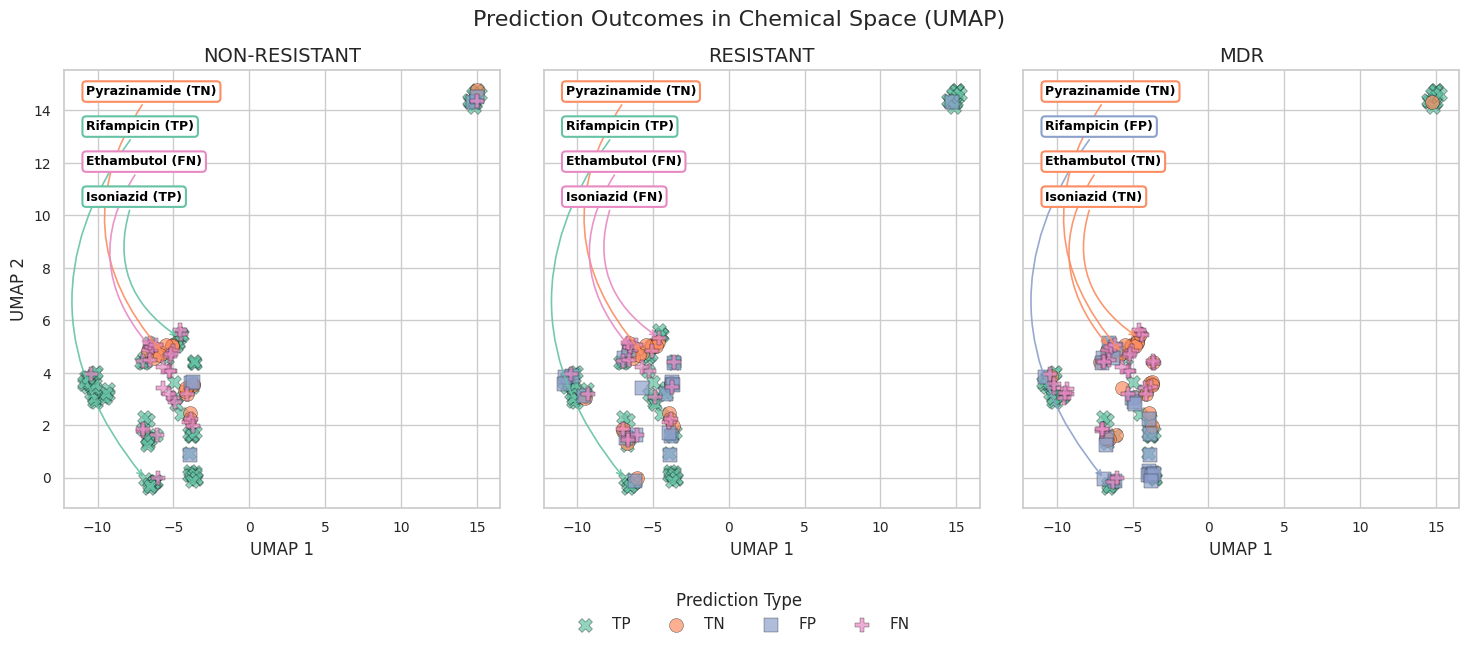

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

FIGURES_DIR = os.path.join(REPO_ROOT, "figures")
os.makedirs(FIGURES_DIR, exist_ok=True)

# ──────────────────────────────────────────────────────────────
# Color and shape styles
error_palette = {
    "TP": "#66c2a5", "TN": "#fc8d62", "FP": "#8da0cb", "FN": "#e78ac3"
}
error_markers = {
    "TP": "X", "TN": "o", "FP": "s", "FN": "P"
}

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# ──────────────────────────────────────────────────────────────
# Define fixed label box positions (in axes coords)
label_positions = {
    "H37RV": (0.05, 0.95),
    "RESISTANT": (0.05, 0.95),
    "MDR": (0.05, 0.95)
}

# ──────────────────────────────────────────────────────────────
for ax, task in zip(axes, task_names):
    task_clean = task.replace("label_", "").upper()
    task_clen_low = task.replace("label_", "")
    subset = df_errors[df_errors["task"].str.lower() == task.lower()]

    # Scatter all points grouped by prediction
    for err in ["TP", "TN", "FP", "FN"]:
        sns.scatterplot(
            data=subset[subset["error_type"] == err],
            x="umap_x", y="umap_y",
            color=error_palette[err],
            marker=error_markers[err],
            s=100, alpha=0.7,
            edgecolor="black", linewidth=0.3,
            label=err, ax=ax
        )

    # Annotate antibiotics at fixed position per subplot
    task_annot = df_annot[df_annot["task"].str.lower() == task.lower()]
    x_anchor, y_anchor = label_positions[task_clean]

    for i, (_, row) in enumerate(task_annot.iterrows()):
        compound = row["compound"]
        pred_type = row["error_type"]
        label = f"{compound} ({pred_type})"
        x, y = row["umap_x"], row["umap_y"]

        # Slight vertical spacing for each label
        dy = -i * 0.08

        ax.annotate(
            label,
            xy=(x, y),
            xytext=(x_anchor, y_anchor + dy),
            textcoords='axes fraction',
            ha="left", va="center",
            fontsize=9, fontweight='bold', color='black',
            bbox=dict(
                boxstyle="round,pad=0.3",
                fc="white",
                ec=error_palette[pred_type],
                lw=1.5
            ),
            arrowprops=dict(
                arrowstyle="->",
                color=error_palette[pred_type],
                lw=1.2,
                alpha=0.9,
                connectionstyle="arc3,rad=0.4"  # 👈 curved arrow!
            )
        )
    if task_clean == "H37RV":
        ax.set_title("NON-RESISTANT", fontsize=14)
    else:
        ax.set_title(task_clean, fontsize=14)
    ax.set_xlabel("UMAP 1", fontsize=12)
    ax.set_ylabel("UMAP 2", fontsize=12)
    ax.tick_params(labelsize=10)

# ──────────────────────────────────────────────────────────────
# Global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title="Prediction Type",
    loc="lower center", bbox_to_anchor=(0.5, -0.08),
    ncol=4, frameon=False,
    fontsize=11, title_fontsize=12
)

# Layout
for ax in axes:
    ax.legend_.remove()

plt.subplots_adjust(top=0.88, bottom=0.15, wspace=0.1)
plt.suptitle("Prediction Outcomes in Chemical Space (UMAP)", fontsize=16)
fig_path = os.path.join(FIGURES_DIR, "umap_prediction_outcomes.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()